In [1]:
import itertools
import uproot
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.stats import chisquare
from scipy.stats import kstest
import statsmodels.api as sm

In [2]:
############### nog dingen pad locaties veranderen ##################

In [3]:
# Define the possible values for year, track type, and polarity
years = [16,17,18]
track_types = ['LL']
magnet_polarities = ['MU', 'MD']

# Base file path template
template_path = '/eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_MM_MVA/Lb2LMM/MC{year}{tracktype}{polarity}/Lb2LMM_procTuple.root'

# This dictionary can hold the file handles
file_handles = {}

# Make every combination of years, tracktype & polarity
for year in years:
    for track_type in track_types:
        for polarity in magnet_polarities:
            # plugs in the all values in the file path
            file_path = template_path.format(year=year, tracktype=track_type, polarity=polarity)
            
            # This generates the variable name for the file handle
            file_name = f'{year}_{track_type}_{polarity}'
                        
            # Opens the file with uproot.open() and stores the handle in the file_handles dictionary
            file_handles[file_name] = uproot.open(file_path)
            print(f"Opened file {file_name}: {file_path}")

Opened file 16_LL_MU: /eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_MM_MVA/Lb2LMM/MC16LLMU/Lb2LMM_procTuple.root
Opened file 16_LL_MD: /eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_MM_MVA/Lb2LMM/MC16LLMD/Lb2LMM_procTuple.root
Opened file 17_LL_MU: /eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_MM_MVA/Lb2LMM/MC17LLMU/Lb2LMM_procTuple.root
Opened file 17_LL_MD: /eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_MM_MVA/Lb2LMM/MC17LLMD/Lb2LMM_procTuple.root
Opened file 18_LL_MU: /eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_MM_MVA/Lb2LMM/MC18LLMU/Lb2LMM_procTuple.root
Opened file 18_LL_MD: /eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_MM_MVA/Lb2LMM/MC18LLMD/Lb2LMM_procTuple.root


In [4]:
#first select variables, loading the full 6 files into swan would take too long. 
selectvariabels = ['JPs_MM', 'JPs_PT', 'Lb_DTF_L0_PV_Lambda0_piplus_PY_0',
                   'Lb_DTF_L0_PV_Lambda0_piplus_PX_0', 'Lb_DTF_L0_PV_Lambda0_pplus_PX_0', 'Lb_DTF_L0_PV_Lambda0_pplus_PY_0', 
                   'Lb_DTF_L0_PV_M_0', 'Lb_DTF_L0_PV_Lambda0_M_0', 'Lb_DTF_L0_PV_Lambda0_piplus_ID_0',
                   'Lb_DTF_L0_PV_Lambda0_pplus_ID_0',
                   'Lb_DTF_L0_PV_chi2_0', 'Lb_DTF_Lb_PV_Lambda0_P_0', 'Lb_DTF_Lb_L0_PV_Lambda0_decayLength_0',
                   'Lb_DTF_Lb_L0_PV_ctau_0', 'Lb_DTF_Lb_PV_decayLength_0', 'Lb_DTF_Lb_PV_chi2_0', 
                   'w_GBR_kinonly_LL', 'w_tracking_P_common_Default', 'w_tracking_Pi_common_Default', 
                   'w_tracking_L1_common_Default', 'w_tracking_L2_common_Default', 'L1_wPIDEffCalib_Muon_nominal', 
                   'L2_wPIDEffCalib_Muon_nominal', 'combined_wTrigL0_correction_nominal']

branches = {}
# Go through the file handles and create branches
for file_name, file_handle in file_handles.items():
    # Extract the branch from the file handle
    branch = file_handle['Lb2JpsiL_mmTuple/DecayTree'].arrays(selectvariabels)
    
    # Define the branch name
    branch_name = file_name  # Extracting the sample name
    
    # Store the branch in the dictionary
    branches[branch_name] = branch

# Print the branches for each file
for branch_name, branch in branches.items():
    print(f"{branch_name} = {branch}")  
    
# branches['17_LL_MU']['Lb_DTF_L0_JPs_PV_M_0'] is an example usage 
# for the charged hadrons I must apply a cut on a varible not yet in the branches

def calculate_protonpt(sample):  
    prx_var1 = 'Lb_DTF_L0_PV_Lambda0_pplus_PX_0'
    pry_var1 = 'Lb_DTF_L0_PV_Lambda0_pplus_PY_0'
    prt_var1 = 'Lb_DTF_L0_PV_Lambda0_pplus_PT_0'
    
    prx_values1 = branches[sample][prx_var1]
    pry_values1 = branches[sample][pry_var1]
    prt_values1 = np.sqrt(prx_values1**2 + pry_values1**2)
    branches[sample][prt_var1] = prt_values1
    
# Calculate new proton pT variables for each sample
for branch_name in branches:
    calculate_protonpt(branch_name)

# for the pions
def calculate_pionpt(sample):
    pix_var1 = 'Lb_DTF_L0_PV_Lambda0_piplus_PX_0'
    piy_var1 = 'Lb_DTF_L0_PV_Lambda0_piplus_PY_0'
    pit_var1 = 'Lb_DTF_L0_PV_Lambda0_piplus_PT_0'
    
    pix_values1 = branches[sample][pix_var1]
    piy_values1 = branches[sample][piy_var1]
    pit_values1 = np.sqrt(pix_values1**2 + piy_values1**2)
    branches[sample][pit_var1] = pit_values1
    
# Calculate new pion pT variables for each sample
for branch_name in branches:
    calculate_pionpt(branch_name)
    
plotvariables = selectvariabels
new_variables = ['Lb_DTF_L0_PV_Lambda0_piplus_PT_0', 'Lb_DTF_L0_PV_Lambda0_pplus_PT_0']
plotvariables.extend(new_variables)

samples_to_plot = list(branches.keys())
all_data = {var: np.empty(0) for var in plotvariables} 
for sample in samples_to_plot:
    for var in plotvariables:
        Lbdata = branches[sample][var]
        all_data[var] = np.concatenate((all_data[var], Lbdata))

# print(all_data['Lb_DTF_L0_PV_M_0'])

16_LL_MU = [{JPs_MM: 2.23e+03, JPs_PT: 4.5e+03, ... combined_wTrigL0_correction_nominal: 1.15}]
16_LL_MD = [{JPs_MM: 3.61e+03, JPs_PT: 1.51e+03, ... combined_wTrigL0_correction_nominal: 1.14}]
17_LL_MU = [{JPs_MM: 3.26e+03, ... combined_wTrigL0_correction_nominal: 0.995}]
17_LL_MD = [{JPs_MM: 4.09e+03, JPs_PT: 2.07e+03, ... combined_wTrigL0_correction_nominal: 1}]
18_LL_MU = [{JPs_MM: 3.59e+03, ... combined_wTrigL0_correction_nominal: 0.985}]
18_LL_MD = [{JPs_MM: 3.09e+03, JPs_PT: 5.91e+03, ... combined_wTrigL0_correction_nominal: 1.03}]


In [5]:
all_data['combined_weight'] = (all_data['w_GBR_kinonly_LL'] * all_data['w_tracking_P_common_Default'] *
        all_data['w_tracking_Pi_common_Default'] *all_data['w_tracking_L1_common_Default'] *
        all_data['w_tracking_L2_common_Default'] *all_data['L1_wPIDEffCalib_Muon_nominal'] *
        all_data['L2_wPIDEffCalib_Muon_nominal'] *all_data['combined_wTrigL0_correction_nominal']) 
tot_weight = all_data['combined_weight']

In [6]:
#For the fit a hyper gaussian will be used 
##################### hyper gaussian ############################
def hgauss(x, resonance_mass, scale, ampl, shape):
    
    # this avoids division by zero
    if scale <= 0:
        raise ValueError("Scale parameter must be positive.")
    # Compute the generalized Gaussian
    with np.errstate(divide='ignore', invalid='ignore'):
        result = ampl * np.exp(-np.abs((x - resonance_mass) / scale) ** shape)
        # Replace NaN values with 0 
        result = np.nan_to_num(result, nan=0.0)
    return result

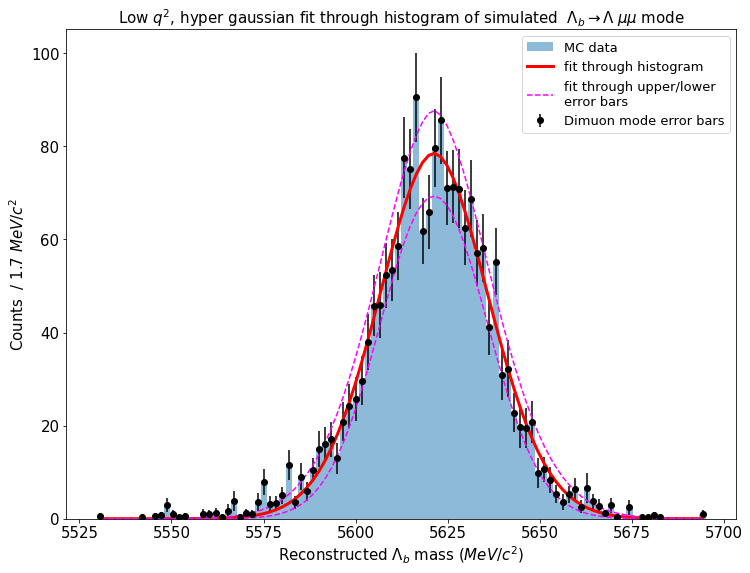

Fit parameters: 5620.723477740994, 20.420579090461107, 80.12960435589787, 1.6637659621781986
2979.0474283390463
3452.0502600910277
2517.343107912534
The integral under the fit is: 2984.70 ± 467.35
The counts under the fit is: 1806.89 ± 282.93
The number of elements passing all cuts 2349


In [14]:
uncut_lbmass = all_data['Lb_DTF_L0_PV_M_0']
mass_muon = 105.66 
lmass_up = 1000*np.sqrt(8) # so that we sit below q2 = 8 GeV^2/c^4
lmass_low = 2* mass_muon 

lqcutlow = lmass_low < all_data['JPs_MM'] 
lqcuthig = lmass_up > all_data['JPs_MM']
lqmask = lqcutlow & lqcuthig

# Now set the other cuts as well
x1 = all_data['Lb_DTF_L0_PV_Lambda0_piplus_ID_0'] == -211.0
x2 = all_data['Lb_DTF_L0_PV_Lambda0_pplus_ID_0'] == 2212.0
x3 = all_data['Lb_DTF_L0_PV_Lambda0_pplus_PT_0'] > 500
x4 = all_data['Lb_DTF_L0_PV_Lambda0_piplus_PT_0'] >500
x5 = all_data['JPs_PT'] > 1000
x6 = all_data['Lb_DTF_L0_PV_Lambda0_M_0'] < 1115+20
x7 = all_data['Lb_DTF_L0_PV_Lambda0_M_0'] > 1115-20
x8 = all_data['Lb_DTF_Lb_L0_PV_ctau_0'] < 100
x9 = all_data['Lb_DTF_Lb_PV_chi2_0'] < 30
#these last cut are only for the plot range and the error bars
x10 = all_data['Lb_DTF_L0_PV_M_0'] > 5500
x11 = all_data['Lb_DTF_L0_PV_M_0'] < 5740
total_cut1 = lqmask & x1 & x2 & x3 & x4 & x5 & x6 & x7 & x8 & x9 & x10 & x11


 # As it is MC data, there are weights:
tot_weight = all_data['combined_weight']
hist1, bin_edges1 = np.histogram(uncut_lbmass[total_cut1], bins=100, weights=tot_weight[total_cut1])
weights_squared1 = tot_weight[total_cut1] ** 2
hist_squared1, _ = np.histogram(uncut_lbmass[total_cut1], bins=100, weights=weights_squared1)
errors1 = np.sqrt(hist_squared1)
bin_centers1 = (bin_edges1[:-1] + bin_edges1[1:]) / 2
bin_width1 = (bin_centers1[1]-bin_centers1[0])

lqav_fit = hist1 
lqup_fit = hist1 + errors1
lqdo_fit = hist1 - errors1

initial_guess1 = [5619, 20, max(hist1), 2]

# Now define the initial parameters for the fit: 
# These are a bit redundant now but I will keep them just in case 
# A problem arose where there was a division by 0 and no optimimization happened
nonzero_mask = (hist1 > 0) & (errors1 > 0)
filtered_bin_centers = bin_centers1[nonzero_mask]
filtered_hist1 = hist1[nonzero_mask]
filtered_errors1 = errors1[nonzero_mask]

# set up the curve fit through the histogram, the histogram +error
# and histogram - error. This way we get an error on the fitintegral
poptav, pcovav = curve_fit(hgauss, bin_centers1, lqav_fit, p0=initial_guess1)
poptup, pcovup = curve_fit(hgauss, bin_centers1, lqup_fit, p0=initial_guess1)
poptdo, pcovdo = curve_fit(hgauss, bin_centers1, lqdo_fit, p0=initial_guess1)

# Initial guess for the parameters
#initial_guess1 = [5619, 20, max(filtered_hist1), 2]
# Fitting the histogram data using curve_fit and the filter
popt1, pcov1 = curve_fit(hgauss, filtered_bin_centers, filtered_hist1, sigma=filtered_errors1, p0=initial_guess1, absolute_sigma=True)

plt.figure(figsize = (12,9))
plt.hist(uncut_lbmass[total_cut1], bins = 100, weights = tot_weight[total_cut1], alpha = 0.5, label = 'MC data')
plt.errorbar(filtered_bin_centers, filtered_hist1, yerr=filtered_errors1, fmt = 'o', color='black', label = 'Dimuon mode error bars')
#plt.plot(filtered_bin_centers, hgauss(filtered_bin_centers, *popt1), linewidth = 2,color='red', label='Fit')

plt.plot(bin_centers1, hgauss(bin_centers1, *poptav), color = 'red', linewidth = 3, label = 'fit through histogram')
plt.plot(bin_centers1, hgauss(bin_centers1, *poptup), color = 'magenta', linestyle = '--', label = 'fit through upper/lower \nerror bars')
plt.plot(bin_centers1, hgauss(bin_centers1, *poptdo), color = 'magenta', linestyle = '--',)

plt.title(r"Low $q^2$, hyper gaussian fit through histogram of simulated  $\Lambda_b \rightarrow \Lambda \; \mu \mu$ mode", fontsize = 15)
plt.legend( fontsize=13)
plt.xlabel('Reconstructed $\Lambda_b$ mass ($MeV/c^2$)', fontsize = 15)
plt.ylabel(f'Counts  / {bin_width1:.1f} $MeV/c^2$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
print(f"Fit parameters: {popt1[0]}, {popt1[1]}, {popt1[2]}, {popt1[3]}")

integral_limits = (5500, 5740)
def fitted_function(x, *popt):
    return hgauss(x, *popt)

lintegral_results = []
for popt in [poptav, poptup, poptdo]:
    lintegral_result, lintegral_error = quad(fitted_function, *integral_limits, args=tuple(popt))
    lintegral_results.append(lintegral_result)

lint = (lintegral_results[2]+lintegral_results[1])/2
linter = lintegral_results[1] - lint
print(lintegral_results[0])
print(lintegral_results[1])
print(lintegral_results[2])
print(f'The integral under the fit is: {lint:.2f} ± {linter:.2f}')
print(f'The number of elements passing all cuts {np.sum(total_cut1)}')




#This will be part of the aforementioned redundant integral
# Define the function for the integral using the fitted parameters
# # Perform the integral
# integral_result, integral_error = quad(fitted_function, *integral_limits)
# print(f"Integral Value: {integral_result:.2f}, Error: {integral_error:.2f}")
# print(f"{integral_result/bin_width1:.2f}")
# print(np.sum(total_cut1))

# # The max and min number of events are given by: 
# max_events = np.sum(hist1 + errors1)
# min_events = np.sum(hist1 - errors1)

# print(f"Maximum number of events: {max_events:.2f}")
# print(f"Minimum number of events: {min_events:.2f}")